**Rotten Tomatoes Reviews: Archive of more than 480,000 critic reviews (fresh or rotten)**

In [ ]:
#import necessary libraries
import numpy as np # numpy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
#Read the data in the csv file using read.csv command from Pandas
data = pd.read_csv('rt_reviews.csv',encoding= 'unicode_escape')


**Exploratory Data Analysis**

In [ ]:
#info() function is used to get a concise summary of the dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


In [ ]:
#we are checking how our dataset looks like by picking first 5 rows using head()
data.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [ ]:
# Replacing labels to 0's and 1's to make it understandable for model.
data['Freshness'] = data['Freshness'].replace("fresh",0).replace("rotten",1)
print(data['Freshness'].value_counts())

1    240000
0    240000
Name: Freshness, dtype: int64


In [ ]:
#getting the total size of the data 
print(data.size)
print(data[ data['Freshness'] == 0].size)
print(data[ data['Freshness'] == 1].size)

960000
480000
480000


In [ ]:
#print the no. of Positive and Neagative sentiment tweets.
print("Number of Fresh reviews in the dataset:",len(data[ data['Freshness'] == 0]))
print("Number of Rotten reviews in the dataset:",len(data[ data['Freshness'] == 1]))

Number of Fresh reviews in the dataset: 240000
Number of Rotten reviews in the dataset: 240000


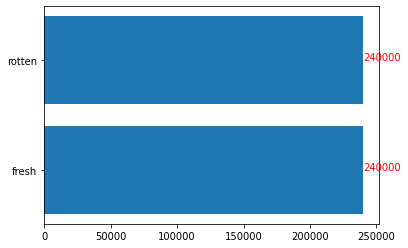

In [ ]:
#Using matplotlib,we are visualizing how balanced our dataset is.. 
import matplotlib.pyplot as plt

x = ["fresh", "rotten"]
y = [len(data[data['Freshness'] == 0 ]),len(data[data['Freshness'] == 1 ])]
plt.barh(x, y)

for index, value in enumerate(y):
  plt.text(value, index, str(value),color='red')

Here our dataset is not balanced at all with Positive sentiments being approximately four times larger than negative sentiments.

**Data pre-processing**

In [ ]:
#we are checking for null values in all the columns
data.isnull().sum()

Freshness    0
Review       0
dtype: int64

In [ ]:
#remove urls from the tweets .Refered from https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/49257661
#checked in https://regexr.com/ -- we tried various combinations and finally took the help of stackoverflow for regex to remove urls

data['Review']  = data['Review'].apply((lambda x:re.sub(r'''(?i)\b((?:(https|http)?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)))


#re.sub(r'^(https|http)?:\/\/.*[\r\n]*', '', x)))
#(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*

data.head(4)

,Freshness,Review
0,0,"Manakamana doesn't answer any questions, yet ..."
1,0,Wilfully offensive and powered by a chest-thu...
2,1,It would be difficult to imagine material mor...
3,1,Despite the gusto its star brings to the role...


In [ ]:
#Below are the data cleaning operations for which we have downloaded important libraries from nltk

import string
import nltk
nltk.download(['punkt','stopwords','wordnet'])
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data preprocessing:
   

1.   Removing non numerical data
2.   Lowering all the text
3.   Spliting sentence into words to remove stopwords
4.   Performing Lemmatization & Removing stopwords from the sentence 
5.   Rejoin the word to make a sentence. 
6.   Store it into corpus array


In [ ]:
#Data preprecessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
text=list()
lines=data['Review'].values.tolist()

for line in lines:
    tokens=word_tokenize(line)
    #convert entire text data to lowercase
    tokens=[w.lower() for w in tokens]
    #remove the punctuations from each word
    table =str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    words=[word for word in stripped if word.isalpha()]
    #filter out stopwords
    stop_words = set(stopwords.words('english'))
    words = [wl.lemmatize(w) for w in words if not w in stop_words]
    text.append(' '.join(words))
print("\n\n")    
print("Total no.of cleaned rows converted to list: ",len(text))




Total no.of cleaned rows converted to list:  480000


In [ ]:
#checking couple of rows from text to understand how our cleaning data looks like.
text[0:2]

['manakamana nt answer question yet make point nepal like rest planet picturesque far peaceable kingdom',
 'wilfully offensive powered chestthumping machismo good clean fun']

In [ ]:
# Splitting the line into words to create number of words in 
splitted_arr_text = [w.split() for w in text]

In [ ]:
# Generating array of splitted lines
np_text = np.array(splitted_arr_text)
splitted_array = np.split(np_text,4)
print(splitted_array)

[array([list(['manakamana', 'nt', 'answer', 'question', 'yet', 'make', 'point', 'nepal', 'like', 'rest', 'planet', 'picturesque', 'far', 'peaceable', 'kingdom']),
       list(['wilfully', 'offensive', 'powered', 'chestthumping', 'machismo', 'good', 'clean', 'fun']),
       list(['would', 'difficult', 'imagine', 'material', 'wrong', 'spade', 'lost', 'found']),
       ...,
       list(['haunted', 'crazed', 'desperation', 'jayma', 'may', 'eye', 'may', 'blinking', 'morsecode', 'so', 'ca', 'nt', 'sure']),
       list(['morel', 'may', 'world', 'greatest', 'actor', 'hand', 'proceeding', 'nt', 'creative', 'enough', 'use', 'talent', 'effectively', 'elevate', 'screenplay', 'something', 'transcends', 'genre']),
       list(['runofthemill', 'stalker', 'narrative', 'timid', 'say', 'anything'])],
      dtype=object), array([list(['numerous', 'tender', 'affecting', 'moment', 'en', 'route', 'finale', 'tearjerker', 'overdrive', 'many', 'productively', 'tangential', 'overarching', 'idea', 'choosing', 'o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


120000


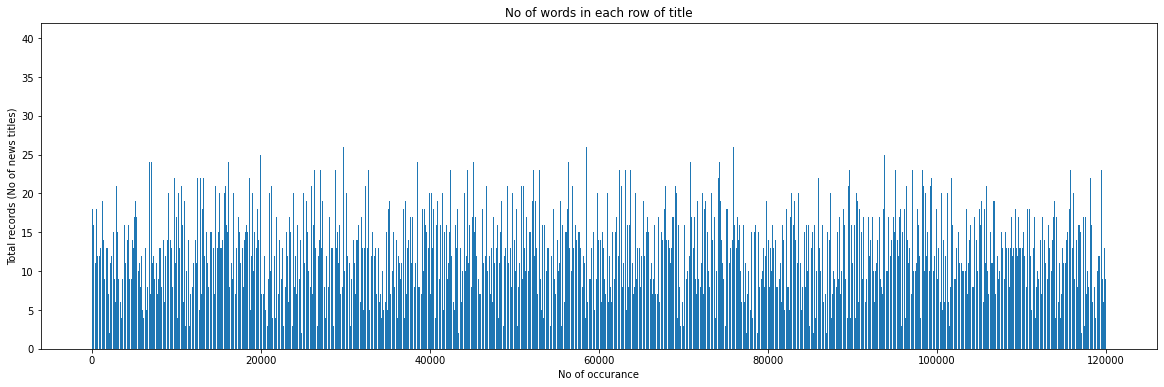

120000


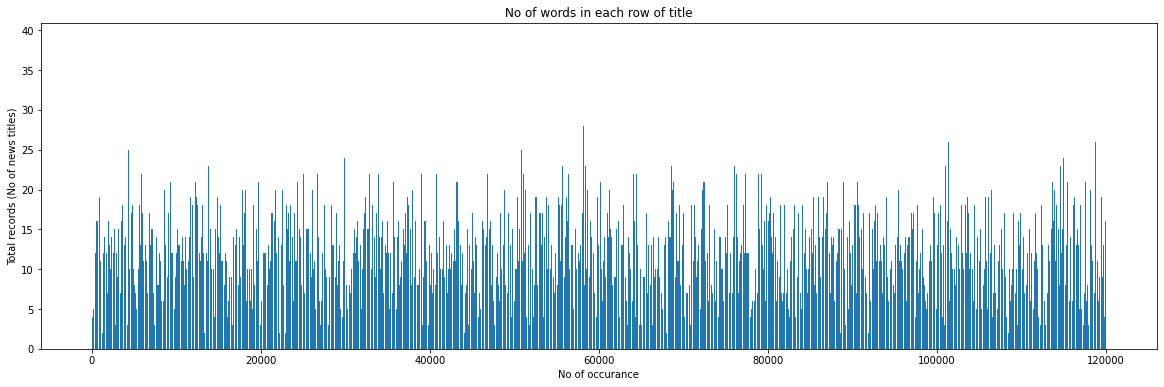

120000


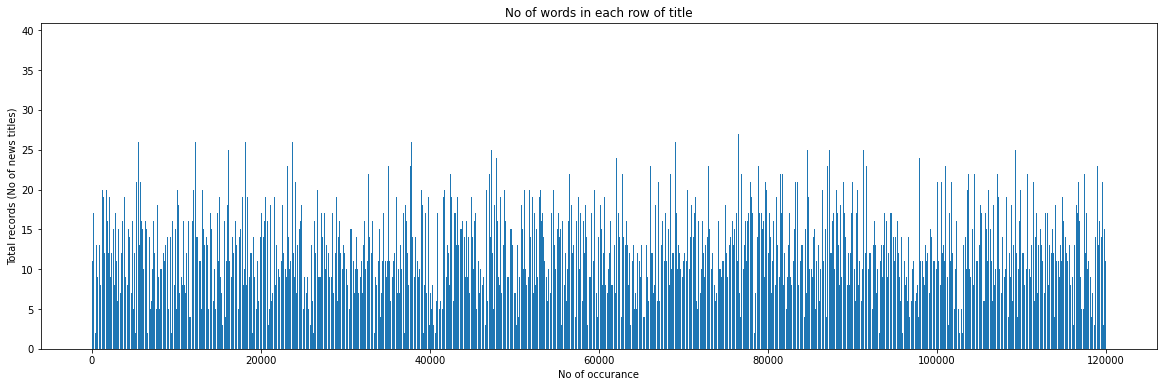

120000


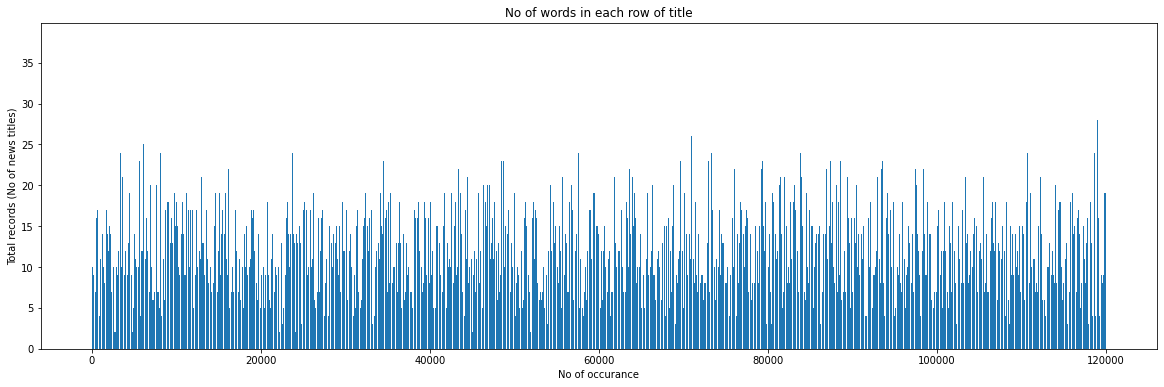

In [ ]:
# No of words in each line
for i in range(0, len(splitted_array)):
  counts = []
  print(len(splitted_array[i]))
  for list in splitted_array[i]:
    counts.append(len(list))
  plt.figure(figsize=(20, 6))
  plt.bar(range(0, len(counts)), counts)
  plt.title('No of words in each row of title')
  plt.xlabel('No of occurance')
  plt.ylabel('Total records (No of news titles)')
  plt.show()

## From gazing above two rows from the text,we can see how each row looks like after removing all the punctuations, urls,stopwords ,non alphabetic characters and converting the entire text to lower case for furthur tokenizing and padding pre-processing steps given below.

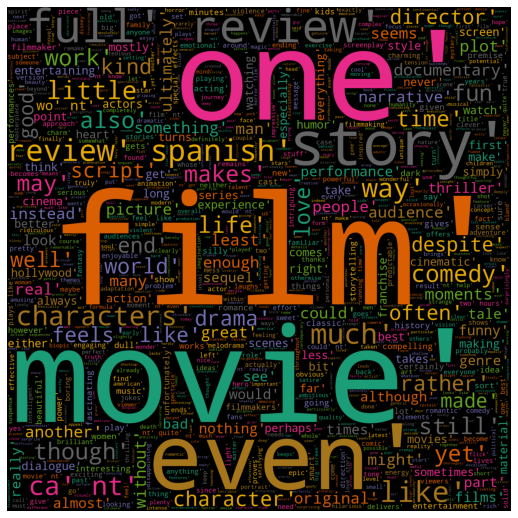

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 1500, height = 1500,background_color ='black',colormap='Dark2',
                      min_font_size = 10, max_words=10729).generate(str(text))

# plot the WordCloud image                    
fig=plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Implementation of Algorithms

In [20]:
#Here, after many tweaks, finally choosing 25% test data and remaining 75% of data to train the model,gave best accuracy.
Y = data['Freshness'].values
X_train, X_test, y_train, y_test = train_test_split(pd.Series(text),Y, test_size = 0.25, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(360000,) (360000,)
(120000,) (120000,)


## TF-IDF vectorizer

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(ngram_range=(1, 2),max_features=100000)    # generating TF-IDF using max_features of 100000
X_train_tf = cv.fit_transform(X_train)
X_test_tf = cv.transform(X_test)
X_train_tf.shape

(360000, 100000)

Dumping pickle file of TfIdf to vectorize the user input

In [60]:
import pickle
pickle_tfidf = open('tfidf.pkl','wb')
pickle.dump(cv, pickle_tfidf)
pickle_tfidf.close()

## Naive Bayes 

In [55]:
# Performing Navie Bayes
nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(X_train_tf, y_train)
y_pred_tf = nb_classifier.predict(X_test_tf)
acc_nb_tfidf = accuracy_score(y_test, y_pred_tf)
print(acc_nb_tfidf)

0.8163666666666667


In [56]:
# tune the hyperparameter alpha for the naive bayes classifier
for alpha in np.arange(0,0.5,.01):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(X_train_tf, y_train)
    y_pred_tune = nb_classifier_tune.predict(X_test_tf)
    score = accuracy_score(y_test, y_pred_tune)
    print("Alpha: {:.2f}  Score: {:.5f}".format(alpha, score))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00  Score: 0.81419
Alpha: 0.01  Score: 0.81548
Alpha: 0.02  Score: 0.81568
Alpha: 0.03  Score: 0.81598
Alpha: 0.04  Score: 0.81606
Alpha: 0.05  Score: 0.81621
Alpha: 0.06  Score: 0.81628
Alpha: 0.07  Score: 0.81639
Alpha: 0.08  Score: 0.81630
Alpha: 0.09  Score: 0.81621
Alpha: 0.10  Score: 0.81637
Alpha: 0.11  Score: 0.81645
Alpha: 0.12  Score: 0.81659
Alpha: 0.13  Score: 0.81664
Alpha: 0.14  Score: 0.81663
Alpha: 0.15  Score: 0.81673
Alpha: 0.16  Score: 0.81681
Alpha: 0.17  Score: 0.81683
Alpha: 0.18  Score: 0.81675
Alpha: 0.19  Score: 0.81671
Alpha: 0.20  Score: 0.81669
Alpha: 0.21  Score: 0.81668
Alpha: 0.22  Score: 0.81669
Alpha: 0.23  Score: 0.81665
Alpha: 0.24  Score: 0.81666
Alpha: 0.25  Score: 0.81664
Alpha: 0.26  Score: 0.81666
Alpha: 0.27  Score: 0.81677
Alpha: 0.28  Score: 0.81681
Alpha: 0.29  Score: 0.81682
Alpha: 0.30  Score: 0.81693
Alpha: 0.31  Score: 0.81700
Alpha: 0.32  Score: 0.81702
Alpha: 0.33  Score: 0.81703
Alpha: 0.34  Score: 0.81705
Alpha: 0.35  Score: 

In [57]:
# Finally fitting NB model using 0.38 as alpha
nb_classifier = MultinomialNB(alpha = 0.38)
nb_classifier.fit(X_train_tf, y_train)
y_pred_tf = nb_classifier.predict(X_test_tf)
acc_nb_tfidf = accuracy_score(y_test, y_pred_tf)
print(acc_nb_tfidf)

0.8171333333333334


In [58]:
import matplotlib.pyplot as plt
# Computations
import itertools

# defining function to generate confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

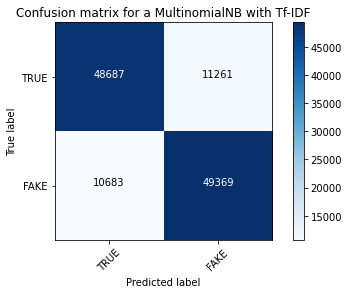

In [59]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred_tf)
confusion_m
# confusion matrix for MultinomialNB
plot_confusion_matrix(confusion_m, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Tf-IDF')

In [61]:
# Dumping pkl file of naive bayes
import pickle
pickle_out = open('naive_bayes.pkl','wb')
pickle.dump(nb_classifier, pickle_out)
pickle_out.close()

## Passive Aggressive Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.8344


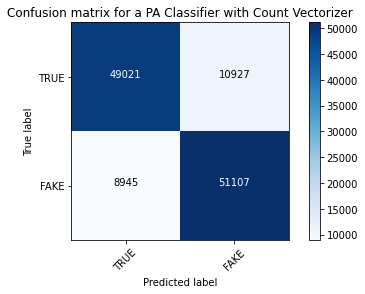

In [62]:
from sklearn import metrics
from sklearn.linear_model import PassiveAggressiveClassifier
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
linear_classifier.fit(X_train_tf, y_train)
pred_linear_count = linear_classifier.predict(X_test_tf)
acc_linear_count = metrics.accuracy_score(y_test, pred_linear_count)
print(acc_linear_count)
cm6 = metrics.confusion_matrix(y_test, pred_linear_count, labels=[0,1])
plot_confusion_matrix(cm6, classes=['TRUE','FAKE'], title ='Confusion matrix for a PA Classifier with Count Vectorizer')


In [63]:
# Dumping pkl file passive_agressive_classifier 
pickle_out_2 = open('passive_agressive_classifier.pkl','wb')
pickle.dump(linear_classifier, pickle_out_2)
pickle_out_2.close()

## Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8351583333333333


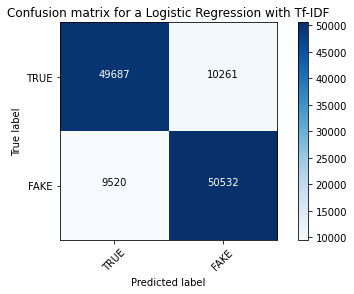

In [67]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train_tf, y_train)
pred_logreg_tfidf = logreg.predict(X_test_tf)
pred_logreg_tfidf_proba = logreg.predict_proba(X_test_tf)[:,1]
acc_logreg_tfidf = metrics.accuracy_score(y_test,pred_logreg_tfidf)
print(acc_logreg_tfidf)
cm4 = metrics.confusion_matrix(y_test, pred_logreg_tfidf, labels=[0,1])
plot_confusion_matrix(cm4, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Tf-IDF')

In [68]:
# Dumping logistic pkl file
pickle_out_4 = open('logistic.pkl','wb')
pickle.dump(logreg, pickle_out_4)
pickle_out_4.close()